# Tutorial: Deep Learning for PDEs - Comparing FEM, PINN, and GNN

Welcome to this introductory tutorial on solving Partial Differential Equations (PDEs) using neural networks. This notebook is designed to guide you through the transition from traditional numerical methods (FEM) to modern deep learning approaches (PINNs and GNNs).

## Introduction: The MLP: the ultimate function map

A **Multilayer Perceptron (MLP)** is a parametric nonlinear function that maps an input vector to an output vector through a sequence of affine transformations and pointwise activation functions.  
Formally, it can be interpreted as a function

$$
\text{MLP}:\; \mathbf{y} = f_{\theta}(\mathbf{x}),
$$

where the parameters $ \theta $ (weights and biases) are learned from data. 


Each layer performs an operation of the form

$$ 
\mathbf{h}^{(k)} = \sigma\!\left( W^{(k)} \mathbf{h}^{(k-1)} + \mathbf{b}^{(k)} \right),
$$


where $ W^{(k)} $ and $ \mathbf{b}^{(k)} $ are the weights and biases of layer $k$, $ \sigma(\cdot) $ is a nonlinear activation function, and $ \mathbf{h}^{(0)} = \mathbf{x} $.

### Minimal two-layer example

For a very simple MLP with **one hidden layer** and an output layer:

$$
\mathbf{h} = \sigma\!\left( W^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \right),
$$
$$
\mathbf{y} = W^{(2)} \mathbf{h} + \mathbf{b}^{(2)}.
$$

$$
\mathbf{y} = f_{\theta}(\mathbf{x}) = W^{(2)}\,\sigma\!\left( W^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)}.
$$

Thus, the overall mapping is the composition of linear transformations and nonlinearities, allowing the network to approximate complex functions from data.


## Introduction: The Poisson Equation

The **Poisson equation** is a fundamental elliptic PDE used in physics and engineering to describe electrostatics, steady-state heat conduction, and fluid flow.

### Mathematical Formulation
We seek to find a scalar function $u(x, y)$ that satisfies:

$$-\Delta u(x, y) = f(x, y) \quad \forall (x, y) \in \Omega$$
$$u(x, y) = 0 \quad \forall (x, y) \in \partial\Omega$$

Where:
- $\Omega$: The **spatial domain**, defined here as a unit square $[0, 1] \times [0, 1]$.
- **Time Domain**: Since this is a steady-state problem, the **simulation time** is $t=0$. The solution represents a static equilibrium. However, the models are built to anticipate future time-dependent variables $u(x, t)$.
- $\Delta$: The Laplace operator $\nabla \cdot \nabla$, representing diffusion or curvature.
- $f(x, y)$: The **source term**, which "drives" the solution (e.g., heat generation or charge density).

### Modeling Approaches
1. **Finite Element Method (FEM)**: A classical mesh-based technique that discretizes the space into simple elements (triangles).
2. **Physics-Informed Neural Networks (PINN)**: A continuous, mesh-free approach that solves the PDE by minimizing residuals using Autograd.
3. **Graph Neural Networks (GNN)**: A physics-aware modern approach that operates on the mesh graph, learning to map topology to solutions.


In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import pytorch_lightning as pl

pl.seed_everything(42)

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"¿Cuda disponible?: {torch.cuda.is_available()}")
print(f"¿Versión de CUDA de PyTorch?: {torch.version.cuda}")
print(f"¿Dispositivos detectados?: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.zeros(1).cuda()
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    # torch.set_float32_matmul_precision('medium') 

print(f"Entorno configurado para hardware: {device}")


Seed set to 42


¿Cuda disponible?: True
¿Versión de CUDA de PyTorch?: 13.0
¿Dispositivos detectados?: 1
Nombre de la GPU: NVIDIA GeForce RTX 5090
Entorno configurado para hardware: cuda


## 1. Defining the Domain: The Geometry Module

Before solving any physics equation, we must define the **Domain** ($\Omega$) where the phenomenon occurs. In this tutorial, we move away from "hardcoded" coordinates to a modular approach using `utils/geometry.py`.

The **Geometry Object** acts as the single source of truth for our entire pipeline:
* **Limits**: Defines the physical boundaries (e.g., a square from 0 to 1).
* **Sampling**: It knows how to generate points inside the domain ($\Omega$) and on its boundaries ($\partial\Omega$).

By centralizing the geometry, if you decide to change the size of the plate or even its shape, you only need to modify the geometry initialization. This ensures that when we compare **FEM**, **PINN**, and **GNN**, we are all looking at the exact same "piece of reality".

* **For FEM**: We will discretize this geometry into a **Mesh** (nodes and elements).
* **For PINN**: We will treat it as a **Point Cloud** (sampling points inside and on the boundaries).
* **For GNN**: We will treat it as a **Graph** (nodes as vertices, connections as edges).

## 2. The Numerical Baseline: Finite Element Method (FEM)

To evaluate if a Neural Network is "smart," we first need a reliable reference. The **Finite Element Method (FEM)** is the industry standard for solving PDEs like the Poisson equation.

Unlike neural networks (PINNs), which are continuous, FEM is a **discrete method**. It transforms our continuous geometry into a collection of small, simple shapes (elements). 

### From Geometry to Mesh
The FEM cannot work with raw ranges; it needs a **Mesh**. We take our `geom` object and discretize it.

* **Nodes**: Specific coordinates where the solution $u$ is calculated.
* **Elements**: Triangles or quads that connect the nodes.

We use the `skfem` library to:
1.  **Discretize** the domain.
2.  **Assemble** the physics (Laplacian and Source terms).
3.  **Solve** the resulting linear system to get the "Ground Truth" solution.

This solution will be our gold standard to measure the accuracy of our PINN and GNN models later.

In [2]:
# ==========================================
# STEP 1: DEFINE PHYSICS & MESH PARAMETERS
# ==========================================
from FEM.fem_solver import get_problem
from config.physics import PoissonGeneral
from config.fem_config import FEM_CONFIG
from utils.geometry import *
from utils.plotting import *
from utils.reporting import *
from utils.metrics import *

# You can change 'sine' to 'const' to see how the solution changes
FEM_CONFIG.update({
    'geometry_type': 'square',      # domain
    'nx': 10,                       # Mesh resolution 
    'ny': 10,
    'porder': 2,                    # base functions
    'mesh': 'quad',                 # mesh type
    'source_type': 'sine',          # source type
    'source_value': 1.0,
})


# Define the domain of our problem
geom = geometry_factory(FEM_CONFIG['geometry_type'], x_range=[0, 1], y_range=[0, 1])
# generate mesh and configure problem
prob = get_problem(geometry=geom, nx=FEM_CONFIG['nx'], ny=FEM_CONFIG['ny'], porder=FEM_CONFIG['porder'], 
                   source_type=FEM_CONFIG['source_type'], mesh_type=FEM_CONFIG['mesh'])
u_exact = prob['u_exact']
doflocs = prob['basis'].doflocs.T

print(f"Configuring FEM for {FEM_CONFIG['source_type']} source term...")
# phys = PoissonPhysics(source_type=FEM_CONFIG['source_type'])
phys = PoissonGeneral(source_type=FEM_CONFIG['source_type'])
print(f"FEM Solution ready with {len(doflocs)} Degree of Freedom (DOF).")

# Display summary
print_config_summary(model=prob, config=FEM_CONFIG, model_type="FEM")

Configuring FEM for sine source term...
FEM Solution ready with 441 Degree of Freedom (DOF).

### FEM CONFIGURATION SUMMARY


,Hyperparameter,Description,Value
0,`project_name`,Model/Solver parameter,out
1,`output_root`,Model/Solver parameter,outputs
2,`geometry_type`,Model/Solver parameter,square
3,`nelem`,Mesh resolution (Elements per side),2
4,`mesh`,Model/Solver parameter,quad
5,`porder`,"Polynomial order (1: Linear, 2: Quadratic)",2
6,`problem`,Model/Solver parameter,Poisson
7,`source_type`,Physics source term function,sine
8,`source_value`,Model/Solver parameter,1.0
9,`epochs`,Maximum training iterations,500


### 2.1 Mesh Configuration: From Continuous to Discrete

Creating a mesh is the process of defining the resolution of our "numerical microscope". In this step, we configure how the geometry will be divided. 

The main parameters are:
* **`nelem` (Resolution)**: The number of divisions along each axis. A higher number captures more detail but requires more memory.
* **`porder` (Polynomial Order)**: Defines the complexity of the solution inside each element. 
    * *Order 1 (Linear)*: The solution is a straight line between nodes.
    * *Order 2 (Quadratic)*: The solution can curve within the element, offering much higher precision.
* **`mesh_type`**: We can use triangles (`tri`) for complex shapes or quadrilaterals (`quad`) for regular grids.

We use a structured triangular mesh with the following parameters (aligned with the `CircleDeterministic.py` reference):

| Parameter | Description | Default Value |
| :--- | :--- | :--- |
| `nelem` | Number of subdivisions along one side | 2 |
| `porder` | Polynomial order of the basis functions | 2 (Quadratic) |
| `source` | Source term type $f(x, y)$ | 'sine' |
| `domain` | Spatial extent | $[0, 1]^2$ |
| `t_sim`  | Simulation Time | Static ($t=0$) |

### 2.2 Visualization: The Calculation Skeleton

Visualization is key to ensuring our discretization is correct. Below, we plot the generated mesh. 

In this plot, you are seeing the **Topology** of the problem:
* **Nodes (Vertices)**: The specific points where the FEM calculates the value of $u(x, y)$. In GNN terms, these will be our **Graph Nodes**.
* **Edges/Elements**: The connections between nodes. In GNN terms, these define the **Graph Edges**.

By passing our `geom` object to the `get_problem` function, the mesh is automatically scaled to the correct physical dimensions, ensuring that our "skeleton" perfectly matches the real-world domain we defined earlier.

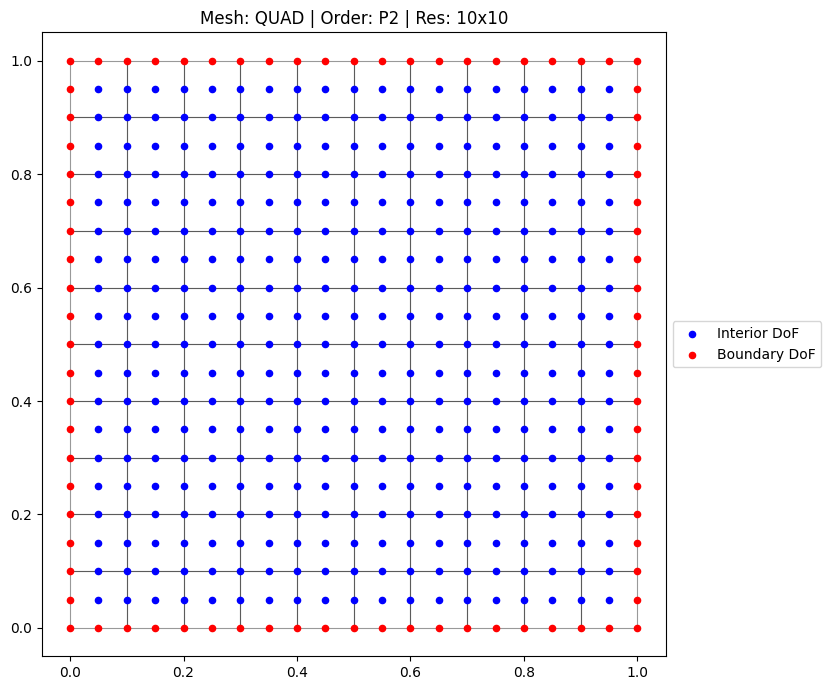

--- Ficha Técnica de la Malla ---
Estructura: QUAD | Orden: P2
Resolución: 10x10 elementos
Total DoFs (Nodos de cálculo): 441


In [3]:
# ==========================================
# STEP 2: AUTOMATIC MESH VISUALIZATION
# ==========================================
# 1. Mesh configuration based on user parameters
prob = get_problem(
    geometry=geom,  
    nx=FEM_CONFIG['nx'],
    ny=FEM_CONFIG['ny'], 
    porder=FEM_CONFIG['porder'], 
    mesh_type=FEM_CONFIG['mesh'], 
    source_type=FEM_CONFIG['source_type'],
)

# 2. Automatic mesh plotting function tri/cuad
plot_fem_mesh(
    prob, 
    title=f"Mesh: {FEM_CONFIG['mesh'].upper()} | Order: P{FEM_CONFIG['porder']} | Res: {FEM_CONFIG['nx']}x{FEM_CONFIG['ny']}"
)

plt.show()

# =========================================
print(f"--- Ficha Técnica de la Malla ---")
print(f"Estructura: {FEM_CONFIG['mesh'].upper()} | Orden: P{FEM_CONFIG['porder']}")
print(f"Resolución: {FEM_CONFIG['nx']}x{FEM_CONFIG['ny']} elementos")
print(f"Total DoFs (Nodos de cálculo): {len(prob['doflocs'])}")

### 2.3 FEM Results: Establishing the Ground Truth

After solving the system, we obtain the distribution of $u(x, y)$—for example, the steady-state temperature across the plate. 

This result is our **Reference Solution**. We will use it for:
1.  **Direct Comparison**: To visually check if the PINN looks similar.
2.  **Error Metrics**: To calculate the exact L2 error of the Neural Network.
3.  **GNN Training**: In supervised learning, this FEM data will be the "label" or "target" that the Graph Neural Network will try to mimic.

Pay attention to the color map: it represents the physical response of the system to the source term $f(x, y)$ we defined.

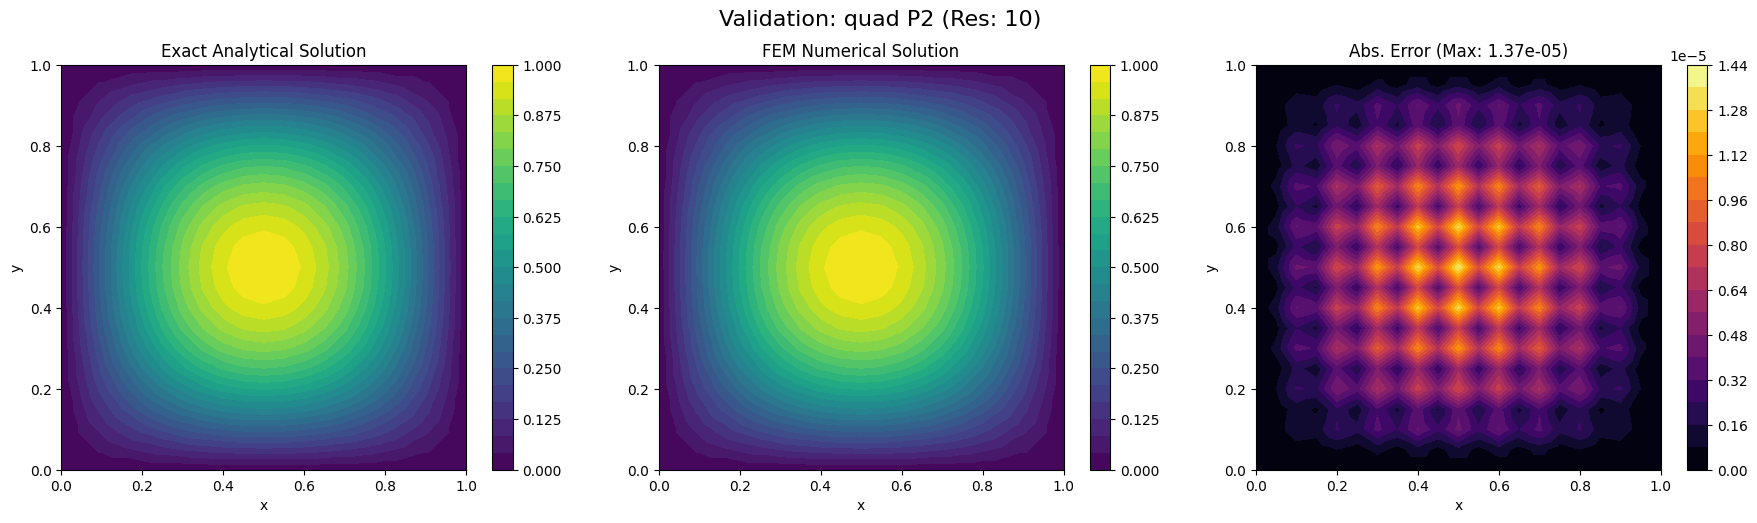

Mean Squared Error (Nodes): 0.000004
REPORT: quad P2


,Métrica,Valor
0,Error Absoluto Máximo (L_inf),1.366225e-05
1,Error Absoluto Promedio (MAE),3.078879e-06
2,MSE (Mean Squared Error),1.925112e-11
3,RRMSE (Relative RMSE),0.000439%


In [4]:
# ==========================================
# STEP 3: SOLVE FEM and VISUALIZE GROUND TRUTH
# ==========================================

# Validation plots
plot_fem_validation(prob, title=f"Validation: {FEM_CONFIG['mesh']} P{FEM_CONFIG['porder']} (Res: {FEM_CONFIG['nx']})")
plt.show()

# Error calculation
l2_error = np.sqrt(np.mean((prob['u'] - prob['u_exact'])**2))
print(f"Mean Squared Error (Nodes): {l2_error:.6f}")

df_metrics, raw_metrics = calculate_fem_metrics(prob['u'], prob['u_exact'])
print(f"REPORT: {FEM_CONFIG['mesh']} P{FEM_CONFIG['porder']}")
display(df_metrics)


## 3. Physics-Informed Neural Networks (PINNs)

The core idea of a PINN is to use a Neural Network as a **universal function approximator** $u_{\theta}(x, y)$ that satisfies a differential equation. 

Unlike the FEM approach we just saw, PINNs are **mesh-free**. Instead of dividing the space into elements, we evaluate the "physical health" of the network at random points. If the network violates the laws of physics (the PDE), we penalize it through the Loss Function.

The Neural Network ($u_\theta$)
Usually a simple **Multilayer Perceptron (MLP)**. It takes spatial coordinates $(x, y)$ as input and outputs the physical quantity of interest $u$.
* **Input:** Coordinates $(x, y)$
* **Output:** Predicted solution $\hat{u}(x, y)$

To guarantee a good solution, a PINN must balance two different goals:
1.  **Physics Loss ($\mathcal{L}_{pde}$)**: Does the network satisfy $-\Delta u = f$ inside the domain?
2.  **Boundary Loss ($\mathcal{L}_{bc}$)**: Does the network respect the fixed values (e.g., $u=0$) at the edges?

### 3.1 The Engine: Automatic Differentiation

The "secret sauce" that allows PINNs to solve PDEs is **Automatic Differentiation (AD)**. 

In traditional methods, we approximate derivatives using finite differences (slopes between mesh nodes). In PINNs, we use the same mechanism that trains standard AI (backpropagation) to calculate **exact analytical derivatives** of the network's output with respect to its input coordinates $(x, y)$.

$$\frac{\partial u}{\partial x} \approx \text{torch.autograd.grad}(u, x)$$

This means our "sensor" for physics is continuous: we can calculate the Laplacian $\Delta u$ at **any** coordinate, not just on a predefined grid.

### 3.2 The Physics-Informed Loss Function

Training a PINN is an optimization problem. We define a total loss function that guides the network toward the correct physical behavior:


$$\mathcal{L}_{total} = \omega_{pde} \mathcal{L}_{pde} + \omega_{bc} \mathcal{L}_{bc}$$

* **Residual Loss ($\mathcal{L}_{pde}$)**: We sample $N_{col}$ points inside the domain and minimize the residual. For the Poisson equation $-\Delta u = f$ the residual is $r := -\Delta u - f$. If $r=0$, the physics are perfectly satisfied. Thus, the loss function is defined to minimize the residual:
  $$\mathcal{L}_{PDE} = \frac{1}{N_{col}} \sum_{i=1}^{N_{col}} |-\Delta u_\theta(x_i) - f(x_i)|^2$$

* **Boundary Loss ($\mathcal{L}_{bc}$)**: We sample $N_{bc}$ points on the edges and force the network to match the boundary conditions (Dirichlet, Neumann, etc.): 
    $$\mathcal{L}_{BC} = \frac{1}{N_{bc}} \sum_{j=1}^{N_{bc}} |u_\theta(x_j) - 0|^2$$


> **Student Note**: The weights $\omega$ (like `lambda_bc` in our code) are crucial. Often, the boundary conditions are harder to learn than the interior physics, so we give them more "importance" during training.

### 3.3 Collocation Points: Where the Physics Happens

These are the points $x_i$ sampled randomly within the domain $\Omega$ where we evaluate the PDE residual. Since the PINN is **mesh-free**, we can sample these points dynamically at every iteration or use a fixed set of points to guide the learning of the underlying physics.

In this notebook, you can choose between two strategies for the points where the physics are evaluated:
1.  **Random Collocation**: High flexibility. The network explores the domain freely.
2.  **FEM-based Nodes**: We use the exact same nodes as the FEM mesh. This is useful for direct 1-to-1 comparisons and to see if the network can "match" the classical solution at specific points.

**Why use random points?** Random sampling (especially if it's dynamic) prevents the network from "memorizing" the solution at specific locations, forcing it to learn the global underlying physical law.

### 3.4 Setting up the PINN Experiment

#### Key Hyperparameters to watch:
* **Max Epochs**: How many times the network will look at the domain.
* **Learning Rate**: The size of the step the optimizer takes. If it's too high, the physics might "explode"; if it's too low, the network will never learn the PDE.
* **Accelerator**: We use `auto` to detect if you have a GPU (CUDA) available, which significantly speeds up the Autograd process.

#### Train, test & validation datasets.

In a PINN, we don't have a "fixed dataset" of images or labels; we have an infinite number of coordinates $(x, y)$ in our domain. You might ask: If the physics are universal, shouldn't I use all possible points for training to get the perfect solution? The answer is No, and here is why: 

1. The Overfitting Trap in Physics
A Neural Network is an incredibly flexible optimizer. If we only evaluate the PDE residual on a fixed, static set of training points, the network might find a "mathematical shortcut": it makes the residual zero exactly at those points while creating wild, non-physical oscillations (instabilities) in between them.

Validation acts as an independent judge. It checks coordinates the network has never "seen" to ensure the solution is smooth and physically consistent everywhere. If the training error is low but the validation error is high, your network is "memorizing" the points instead of "understanding" the PDE.

2. Stability and Convergence
Physical systems are sensitive to boundaries and gradients. By monitoring a separate Validation Set, we can detect if the solution is becoming unstable or "exploding" before the training ends. It is our primary tool to ensure the numerical stability of the neural solver.

In a standard AI project, you divide your "data" into three sets. In a PINN, we do the same, but instead of "data samples", we divide our **Geometry**:

-  **Training Set (Collocation Points)**: The training set is the portion of the data used to fit the model parameters, allowing the algorithm to learn patterns from examples. In PINNs, these are the coordinates $(x, y)$ where the neural network will evaluate the PDE. The "loss" here is the physics residual. 

-  **Validation Set**: The validation set is used during development to tune hyperparameters, evaluate convergence and monitor overfitting. 

-  **Test Set (Ground Truth Comparison)**: If available, it measures real accuracy of the model. It is an independent and unbiased evaluation of the final model’s predictive performance.

**Why is this relevant?** Because it allows us to prove that the PINN can generalize the solution to the entire domain, not just the points it "saw" during training.

#### Data loaders 

The **DataLoader** is the pipe that connects our points to the GPU. 

* **Format**: In PINNs, the DataLoader delivers a dictionary or a tensor of **raw coordinates** $(x, y)$. 
* **Batches**: We don't feed all points at once. We send them in small groups (batches). For example, if we have 2000 points and a `batch_size=32`, the optimizer will update the physics 63 times per epoch.
* **Format in this project**: Our `PinnDataset` organizes two types of inputs: `'pde'` (interior points) and `'bc'` (boundary points).

## 3.6. STEP 1: Initializing the PINN Strategy

Now we move to the code. In this first step, we define the "Brain" (Hyperparameters) and the "Eyes" (Collocation points).

**CRITICAL CONCEPT**: Notice that in the following cell, we are **NOT** loading any experimental data or solutions. We are only generating **coordinates**. 
* We define how many points we want in the interior (`n_train`).
* We define how many points we want on the boundaries (`n_bc`).
* We visualize them to ensure they cover the domain $\Omega$ correctly.

The PINN starts completely "blind". It only has a set of coordinates and a mathematical rule (the PDE) to follow.

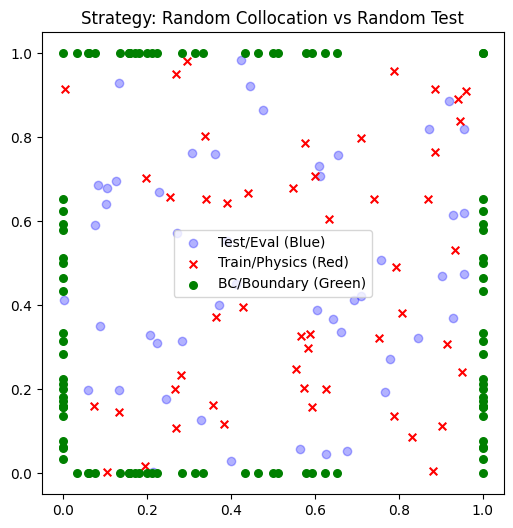

In [5]:
# ============================================================
# STEP 1: DATA GENERATION & STRATEGY
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from PINN.pinn_module import PinnDataset, ValDataset
from config.pinn_config import PINN_CONFIG
from utils.geometry import *
from utils.train_utils import * 
from utils.pinn_utils import *

PINN_CONFIG.update({
    'geometry_type': 'square',
    'n_train': 50,        
    'n_test': 50,
    'n_bc': 100,
    'lambda_bc': 200.0,
    'hidden': 20,
    'num_layers': 2,
    'lr': 1e-3,
    'epochs': 100, # con 5000 va bastante bien
    'batch': 50,
    'source_type': 'sine',
    'source_value': 1.0,
    'use_fem_for_train': False,
    'use_fem_for_test': False,
    'layer_norm': False,
})

# my_physics = PoissonPhysics(source_type=source_type)
my_physics = PoissonGeneral(source_type=PINN_CONFIG['source_type'])

# Initialize geometry and sampler
geom = geometry_factory(PINN_CONFIG['geometry_type'], x_range=[0, 1], y_range=[0, 1])
sampler = PINNSampler(geom, device=device)

# Define Collocation points (Interior)
if PINN_CONFIG['use_fem_for_train']:
    # train_pts = torch.tensor(prob['doflocs'], dtype=torch.float32)
    train_pts = torch.tensor(prob['doflocs'], dtype=torch.float32, device=device)
    train_label = "FEM Nodes"
else:
    train_pts = sampler.sample_interior(PINN_CONFIG['n_train'])
    train_label = "Random Collocation"

# Define Boundary points (BCs) - 2D Logics
bc_coords = sampler.sample_boundary(PINN_CONFIG['n_bc'])

# Define Test/Validation points
if PINN_CONFIG['use_fem_for_test']:
    # if use fem points: compare vwith exact solution 
    test_pts = torch.tensor(prob['doflocs'], dtype=torch.float32, device=device)
    test_val = torch.tensor(prob['u'], dtype=torch.float32, device=device).view(-1, 1)
    test_label = "FEM Mesh"
else:
    # if use rnd points: evaluate residual  
    test_pts = sampler.sample_interior(PINN_CONFIG['n_test']) 
    test_val = None             # Random points
    test_label = "Random Test"

# DataLoaders en PinnModule 
train_ds = PinnDataset(geometry=geom, pde_pts=train_pts, bc_pts=bc_coords)
train_loader = DataLoader(train_ds, batch_size=PINN_CONFIG['batch'], shuffle=True, num_workers=0)

val_ds = ValDataset(geometry=geom, pts=test_pts, vals=test_val)
val_loader = DataLoader(val_ds, batch_size=len(test_pts))

# --- Visualización Adaptativa ---
plot_pinn_strategy(
    train_pts.detach().cpu().numpy(), 
    bc_coords.detach().cpu().numpy(), 
    test_pts.detach().cpu().numpy(), 
    title=f"Strategy: {train_label} vs {test_label}"
)

### 3.7. STEP 2: Understanding the Physics-Informed Neural Network (PINN)

To solve a PDE like the Poisson equation without a mesh, we use a Neural Network as a function approximator $u_{\theta}(x, y)$. Unlike standard deep learning, we don't only minimize the error against data; we minimize the **residual of the PDE**.

### The Core Components
The project is divided into three main modules that you should understand:
1. **`pinn_config.py` (Predefined configurations)**: Before building the model, we define a dictionary (or a configuration object) called pinn_config. Think of this as the control panel of the neural network.
    - Architecture: Here we define how many neurons and layers the network has.
    - Hyperparameters: We set the learning rate, the weight of the boundary conditions (lambda_bc), and the number of epochs.
    - Physics Link: This is where we tell the PINN which physical law it must follow.

2.  **`physics.py` (The Rules)**: The Mathematical Recipe. The PINN does not "know" physics by default. We must teach it the rules through a specific script: physics.py. This module is designed to be pluggable: you can swap the Poisson equation for any other differential equation (like Fourier or Cattaneo) as long as you provide the following three components:
    - The Source Term ($f$). In our Poisson example, this is the heat source or charge distribution.
       * Poisson case: $f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)$.
       * Implementation: The model evaluates this function at every coordinate $(x, y)$ to know what "force" is acting on the system.
    - The Laplacian and the Residual ($\mathcal{R}$). This is the heart of the PINN. We use Automatic Differentiation to calculate the Laplacian ($\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$).
        * The Residual: We define $\mathcal{R} = \Delta u + f$
        * The Goal: If the network is doing its job perfectly, $\mathcal{R}$ should be zero everywhere. The training process is simply the network trying to minimize this residual.
    - Boundary Conditions (BCs). Finally, we define the "rules" at the edges of our domain.
        * Poisson case (Dirichlet): We force $u(x, y) = 0$ at the four walls of the square.
        * Implementation: The physics module checks the network's prediction at the boundary coordinates and calculates the error against the target value (zero).

3.  **`pinn_module.py` (The Engine)**: This contains the `PINNSystem` (built with PyTorch Lightning). It handles the training loops, the optimization (Adam/LBFGS), and the logging of metrics. This has been designed to be agnostic to the underlying physics and dimensionality, so no modifications should be required (in principle). At each training step it:
    1. Takes a batch of coordinates from the DataLoader.
    2. Asks the network for a prediction $u$.
    3. Calls physics.py to calculate how much that prediction violates the PDE.
    4. Computes the Total Loss (PDE + Boundary) and tells the optimizer how to adjust the neurons.

---

> **NOTE** The beauty of this modular structure is that the pinn_module.py (the engine) never changes. To solve a more complex problem, you only update physics.py:


Tratamiento de Condiciones de Contorno (BCs): A diferencia de las PINNs, donde las BCs se imponen mediante una penalización en la función de pérdida, en las GNNs supervisadas existen varias estrategias:

Como Características (Features): 
- Añadimos un canal extra a los nodos (is_boundary) que indica si el nodo pertenece a la frontera. Esto permite a la red aprender que esos puntos tienen un comportamiento especial.
- Imposición Fuerte: Se pueden sobreescribir los valores predichos en los nodos de contorno con los valores reales antes de calcular la pérdida.
- Propagación: El mecanismo de Message Passing permite que la información de los nodos de contorno (donde $u=0$) "fluya" hacia el interior, informando al resto de la malla sobre los límites físicos del problema.

In [6]:
# ============================================================
# STEP 2: MODEL & TRAINER SETUP
# ============================================================
import torch
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from PINN.pinn_module import PINNSystem
from config.physics import *
from utils.train_utils import GradientMonitor, LossPlotterCallback

# my_physics = PoissonPhysics(source_type=PINN_CONFIG['source_type'], scale=PINN_CONFIG['source_value'])
my_physics = PoissonGeneral(source_type=PINN_CONFIG['source_type'], scale=PINN_CONFIG['source_value'])
pinn = PINNSystem(**PINN_CONFIG, physics=my_physics)

loss_plotter = LossPlotterCallback(
    model_name="Poisson PINN"
)

# Define Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=300, # Increased for PINNs as they can plateau
        mode='min', 
        min_delta=1e-6,
        verbose=True
    ),
    ModelCheckpoint(
        monitor='val_loss', 
        save_top_k=1, 
        mode='min',
        filename='best_pinn_{epoch}'
    ),
    GradientMonitor(verbose=True),
    loss_plotter
]

trainer = pl.Trainer(
    max_epochs=PINN_CONFIG['epochs'],
    accelerator="auto",
    devices=1,
    callbacks=callbacks,
    log_every_n_steps=20,
)

from utils.reporting import print_config_summary

print_config_summary(pinn, PINN_CONFIG, model_type="PINN")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



### PINN CONFIGURATION SUMMARY


,Hyperparameter,Description,Value
0,`project_name`,Model/Solver parameter,out
1,`output_root`,Model/Solver parameter,outputs
2,`geometry_type`,Model/Solver parameter,square
3,`nelem`,Mesh resolution (Elements per side),2
4,`mesh`,Model/Solver parameter,quad
5,`porder`,"Polynomial order (1: Linear, 2: Quadratic)",2
6,`problem`,Model/Solver parameter,Poisson
7,`source_type`,Physics source term function,sine
8,`source_value`,Model/Solver parameter,1.0
9,`epochs`,Maximum training iterations,100


### 3.8. Execution, Inference and Comparison

Once the strategy is set and the model is assembled, we proceed to the final stage: training the "neural solver" and verifying if it has truly learned the laws of physics.

1. Training

    Before starting, we set torch.set_float32_matmul_precision('high'). This allows PyTorch to use the specialized Tensor Cores in modern GPUs (like NVIDIA Ampere or newer), significantly accelerating the training without compromising the precision required for PDEs.

    When we call trainer.fit(), the PINN begins its optimization loop. In each epoch, the network adjusts its internal weights to minimize the PDE Residual (internal consistency) and the Boundary Loss (sticking to the edges).

2. Inference
    After training, we switch the model to eval() mode. This is crucial because it deactivates specific training layers (like Dropout) and ensures the model is ready for pure prediction.
    - torch.no_grad(): We wrap the inference in this context to tell PyTorch not to calculate gradients, which saves memory and computing power.
    - The Goal: We pass the exact coordinates of the FEM mesh to the PINN. This allows us to have a point-by-point prediction that we can directly compare with the classical solution.

3. Visual comparison
    A scientific result is only valid if it can be quantified. We use two types of visualizations:
    - The Comparison Map: We plot the FEM solution side-by-side with the PINN prediction. At a glance, the physical patterns (the "shape" of the heat or pressure) should look identical.
    - The Error Map ($|u_{FEM} - u_{PINN}|$): This is the "Truth Map." It shows exactly where the neural network is struggling.

> **NOTE**: If you see high error concentrated only at the boundaries, it means your lambda_bc was too low. If the error is high everywhere, the network might need more layers (n_layers) or more training time.

You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ MLP  │  4.4 K │ train │     0 │
└───┴───────┴──────┴────────┴───────┴───────┘

Trainable params: 4.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: 
`isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` 
instead.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/torch/autograd/graph.py:869: UserWarning: 
Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... 
(Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:335.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:317: The 
number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

Metric val_loss improved. New best score: 93.688
Metric val_loss improved by 0.402 >= min_delta = 1e-06. New best score: 93.287
Metric val_loss improved by 0.411 >= min_delta = 1e-06. New best score: 92.876
Metric val_loss improved by 0.414 >= min_delta = 1e-06. New best score: 92.461
Metric val_loss improved by 0.419 >= min_delta = 1e-06. New best score: 92.042
Metric val_loss improved by 0.425 >= min_delta = 1e-06. New best score: 91.618
Metric val_loss improved by 0.433 >= min_delta = 1e-06. New best score: 91.185
Metric val_loss improved by 0.445 >= min_delta = 1e-06. New best score: 90.740
Metric val_loss improved by 0.462 >= min_delta = 1e-06. New best score: 90.278
Metric val_loss improved by 0.479 >= min_delta = 1e-06. New best score: 89.799
Metric val_loss improved by 0.500 >= min_delta = 1e-06. New best score: 89.299
Metric val_loss improved by 0.526 >= min_delta = 1e-06. New best score: 88.773
Metric val_loss improved by 0.557 >= min_delta = 1e-06. New best score: 88.216
Met

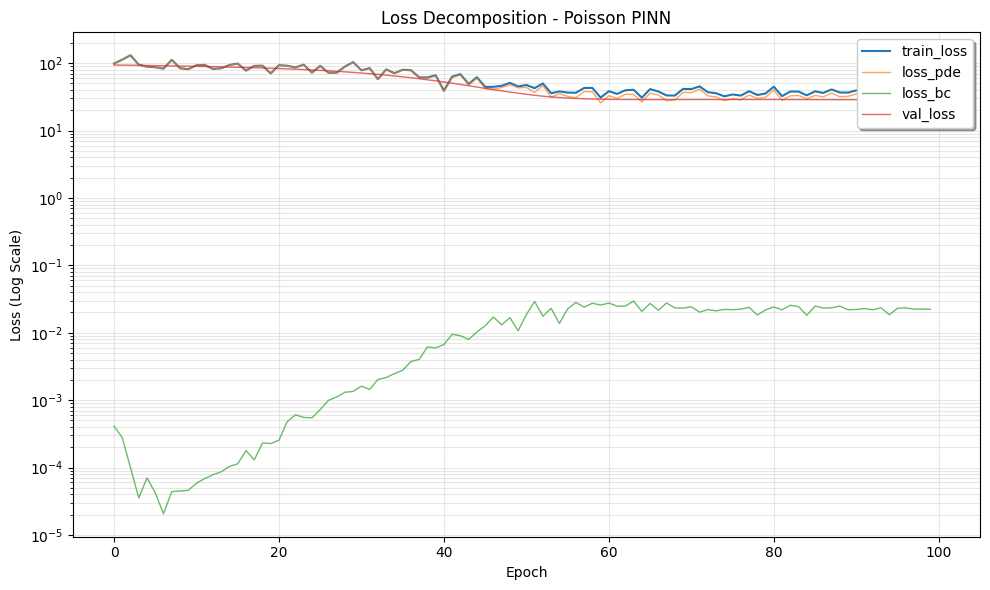

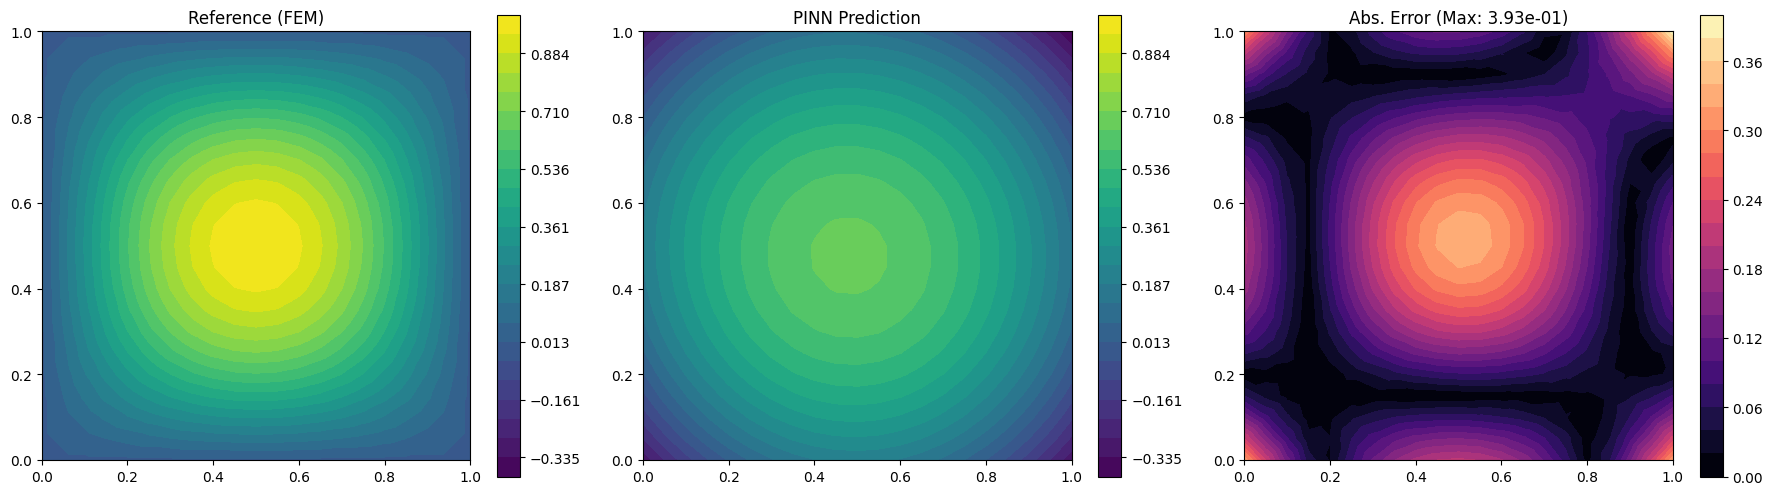

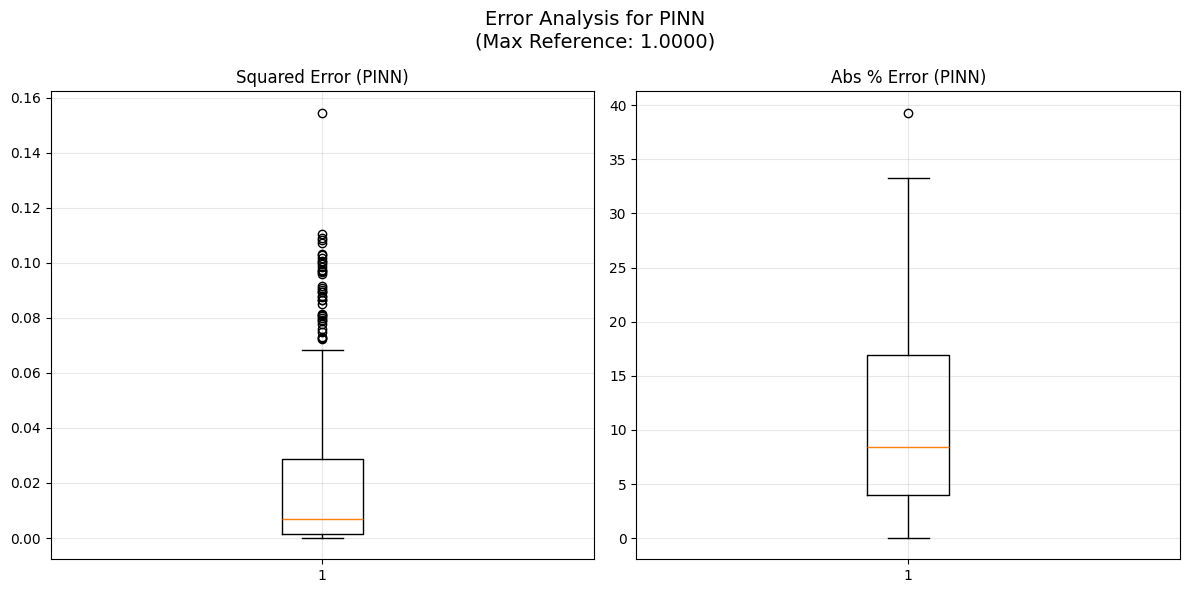

In [7]:
# ============================================================
# STEP 3: Fit model (train)
# ============================================================

# torch.set_float32_matmul_precision('high') 
trainer.fit(pinn, train_dataloaders=train_loader, val_dataloaders=val_loader)

# ============================================================
# STEP 4: verify model (visualize solution)
# ============================================================

# Put in eval mode for inference
pinn.eval()
with torch.no_grad():
    x_test = torch.tensor(prob['doflocs'], dtype=torch.float32).to(pinn.device)
    u_pinn_pred = pinn(x_test).cpu().numpy().flatten()

# Results comparison 
fig_comp = plot_comparison_with_pinn(pinn, prob['u'], prob['doflocs'])
plt.show()

# Error analysis
fig_err = plot_error_analysis(u_fem=prob['u'], u_model=u_pinn_pred, model_name="PINN")
plt.show()


## 4. Graph Neural Network (GNN) 

A Graph Neural Network (GNN) does not operate on pixels or sequences, but on mesh topologies. To solve the Poisson equation, the GNN employs a message passing scheme that allows physical information to propagate throughout the domain.


### Message Passing Graph Network Components

- **MLP (Multilayer Perceptron):**  
  Acts as the main learning module of the architecture. It serves as a universal approximator of nonlinear mappings of the form  

  $$
  \mathbf{y} = f(\mathbf{x}; \boldsymbol{\theta}),
  $$  

  where $\boldsymbol{\theta}$ denotes the trainable parameters.  
  Within message passing networks, MLPs are typically used to parameterize the **edge**, **node**, and sometimes **global** update functions, enabling flexible nonlinear transformations of features.

- **Edge Processor:**  
  Encodes the **connectivity and geometric relationships** of the mesh or graph.  
  It processes information associated with pairs of connected nodes, typically including:

  - Node positions $ (\mathbf{x}_i, \mathbf{x}_j) $  
  - Relative geometric descriptors $ \mathbf{x}_{ij} $ 
  - Edge or flow-related attributes $ \mathbf{a}_{i,j} $  

  This component models **local interactions**, defining how two neighboring nodes influence each other and which information is exchanged based on geometry and physical properties.  
  In practice, it is usually implemented as an MLP that outputs a **message vector** along each edge.

- **Node Processor:**  
  Represents the **state evolution at each mesh node**.  
  It operates on:

  - Node state variables $ \mathbf{u}_i $  
  - Node spatial coordinates $ \mathbf{x}_i $  
  - Aggregated messages received from neighboring nodes $ \mathbf{e}_i $

  Its role is to compute the **updated node representation**, determining how the physical quantity of interest (e.g., a potential $u$, velocity, or pressure) evolves after neighborhood interaction.  
  This update is also commonly parameterized by an MLP.

- **Message Passing Mechanism:**  
  Defines the **iterative exchange of information** between each node $n_i$ and its neighbors $n_j$.  
  Messages are computed locally along edges and then **aggregated** (e.g., by summation, mean, or attention) at each node before applying the node update function.

  Because each message passing step only propagates information across **one-hop neighborhoods**, multiple iterations are required to allow information to travel across **longer graph distances**, effectively increasing the receptive field of the network.

  This iterative local-to-global propagation enables graph neural networks to approximate solutions of **spatially distributed physical systems** and **partial differential equations** defined on meshes.

### Information Flow (Message Passing Steps)
The computational process is divided into three critical stages that occur at each processor iteration:

1.  Message Computation (EdgeProcessor):
    For each edge connecting a neighboring node $j$ (sender) to the central node $i$ (receiver), a message ($\mathbf{e}_{i,j}'$) is computed. This message depends on the spatial relationship and the current state:
    - Current states of the nodes: $\mathbf{u}_i, \mathbf{u}_j$
    - Coordinates, $\mathbf{x}_i, \mathbf{x}_j,$, relative distance $\mathbf{x}_ij$, and edge attributes, $\mathbf{a}_{i,j}$

    $$
    \mathbf{e}_{i,j}' = MLP_{edge} \big( \mathbf{x}_i, \mathbf{x}_j, \mathbf{u}_i, \mathbf{u}_j, \mathbf{a}_{i,j} \big)
    $$

* 2: Aggregation: Node $i$ collects all messages from its neighborhood $\mathcal{N}(i)$.  
    To ensure invariance to the ordering of neighbors and to the number of connections (**permutation invariance**), a symmetric aggregation function is used:

    $$
    \mathbf{\bar{e}}_{i} = \sum_{j \in \mathcal{N}(i)} \mathbf{e}_{i,j}'
    $$    

    **Note:** Other functions such as the mean ($\text{mean}$) or maximum ($\text{max}$) can also be used, although summation is the standard choice to preserve physical magnitudes.


* 3: Node update (NodeProcesor): Finally, node $i$ updates its latent state by combining its current information with the aggregated message summary.  
    In residual architectures such as **MeshGraphNet**, this is formulated as an increment:
    $$
    \mathbf{u}_{i}' = \mathbf{u}_{i} + MLP_{node} \big( \mathbf{u}_{i}, \mathbf{\bar{e}}_{i} \big)
    $$
 


### GNN Configuration

| Hyperparameter | Description | Value |
| :--- | :--- | :--- |
| `hidden_dim` | Width of Graph layers | 32 |
| `num_layers` | Message passing steps | 3 |
| `lr` | Learning rate | 1e-3 |
| `epochs` | Training iterations | 500 |
| `supervised` | Training against FEM targets | Yes |
| `connectivity` | Graph edges type | Mesh-based |

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generando malla de entrenamiento: 2x2...
Generando malla de entrenamiento: 5x5...
Generando malla de entrenamiento: 8x8...
Generando malla de entrenamiento: 10x10...
Generando malla de validación (fina): 50x50...


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type         ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ MeshGraphNet │ 52.0 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss      │      0 │ train │     0 │
└───┴─────────┴──────────────┴────────┴───────┴───────┘

Trainable params: 52.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 52.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 115                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: 
`isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` 
instead.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 0.097
Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.085
Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.081
Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.074
Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.071
Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.069
Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.066
Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.062
Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.053
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.052
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.051
Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.047
Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.036
Metric val_loss improved by 0.007 >= min

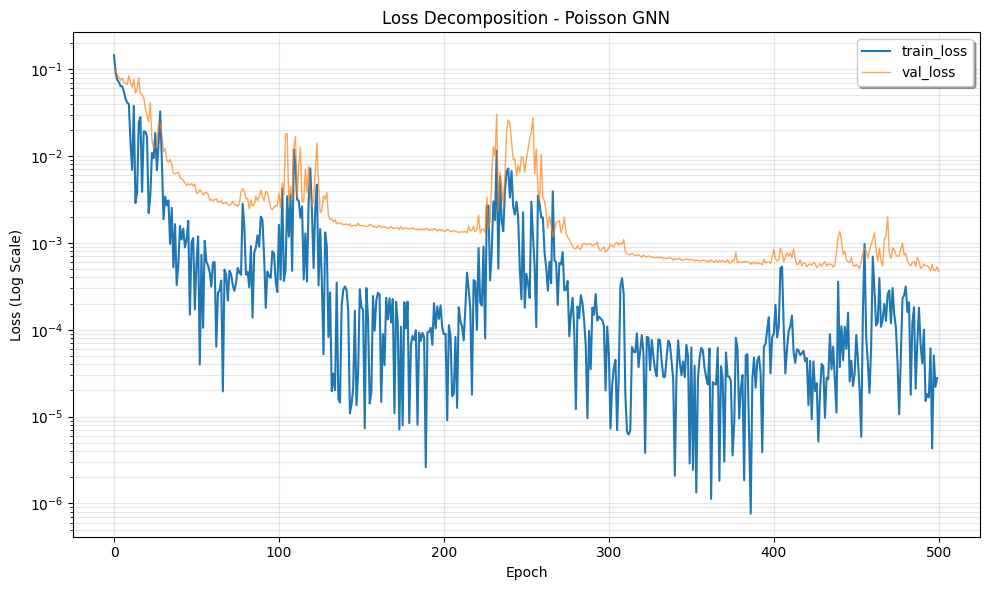

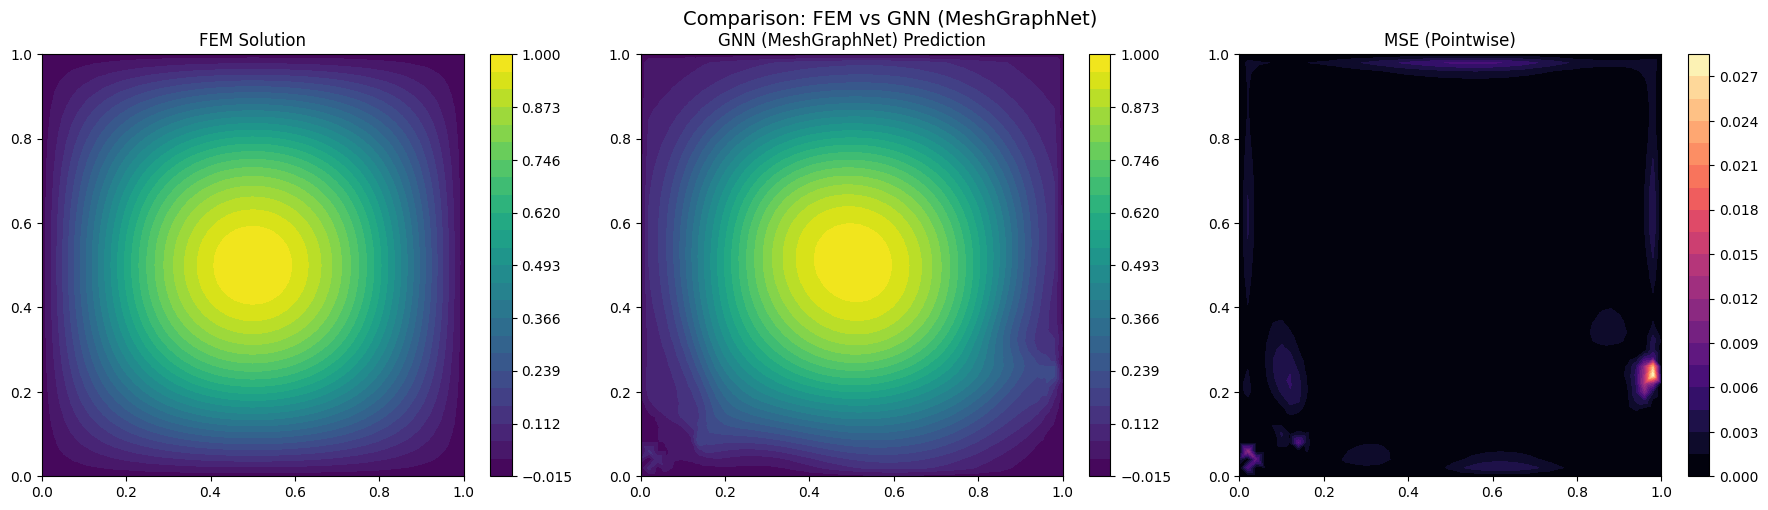

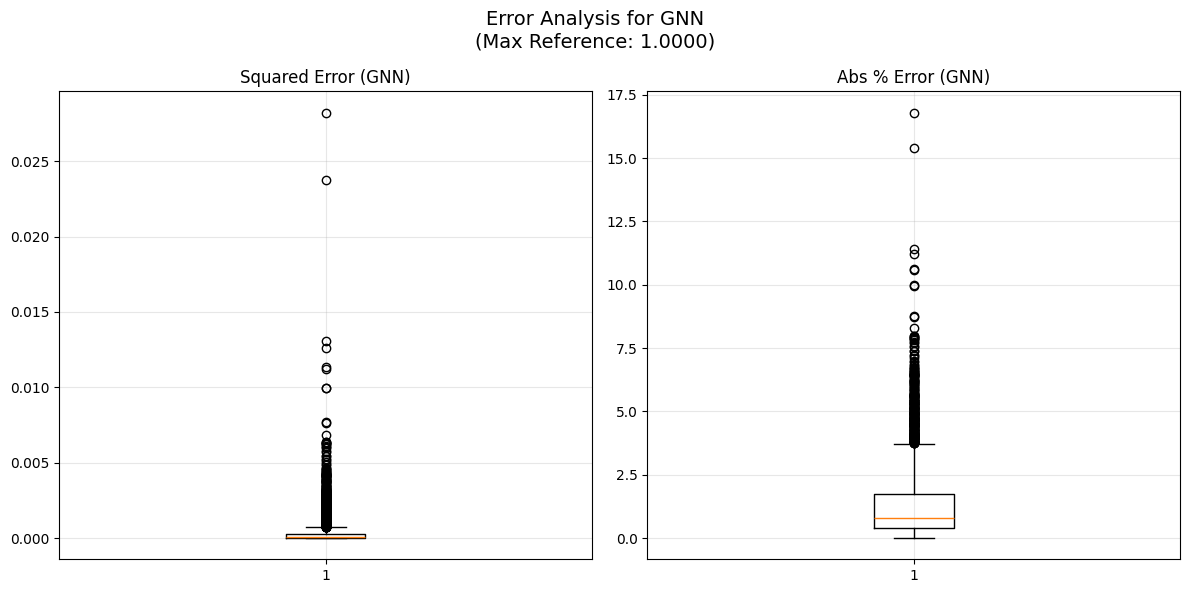

In [8]:
# ============================================================
# Step 1: GNN configuration
# ============================================================
import torch
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Local modules
from FEM.fem_solver import get_problem
from GNN.MeshGraphNet import MeshGraphNet, MGNSystem
from config.gnn_config import GNN_CONFIG
from utils.gnn_utils import FEM_to_GraphData
from utils.train_utils import GradientMonitor, LossPlotterCallback
from utils.geometry import *

# 0. Configuración de parámetros
GNN_CONFIG.update({
    'geometry_type': 'square',      # domain
    'nx': 10,                       # Mesh resolution 
    'ny': 10,
    'porder': 1,                    # base functions
    'source_type': 'sine',          # source type
    'source_value': 1.0,
    'hidden': 20,
    'num_layers': 2,
    'latent_dim': 3,       # Espacio latente para encoders y procesadores
    'lr': 1e-3,
    'epochs': 500,
    'batch': 1,
    'msg_passes': 5,
    'node_in': 3,           # [x, y, is_boundary] <-- Gestión de BCs
    'edge_in': 3,           # [dx, dy, dist]
    'decoder_out': 1,
})

geom = geometry_factory(GNN_CONFIG['geometry_type'], x_range=[0, 1], y_range=[0, 1])
train_resolutions = [(2, 2), (5, 5), (8, 8), (10, 10)]  # diferentes mallas para entrenar
val_resolution = (50, 50)                               # Una malla fina para validar

# 1. Generar mallas de ENTRENAMIENTO
train_graphs = []
for nx, ny in train_resolutions:
    print(f"Generando malla de entrenamiento: {nx}x{ny}...")
    prob = get_problem(
        geometry=geom, nx=nx, ny=ny, 
        porder=GNN_CONFIG['porder'], 
        source_type=GNN_CONFIG['source_type']
    )
    train_graphs.append(FEM_to_GraphData(prob))

# 2. Generar malla de VALIDACIÓN
print(f"Generando malla de validación (fina): {val_resolution[0]}x{val_resolution[1]}...")
prob_val = get_problem(
    geometry=geom, nx=val_resolution[0], ny=val_resolution[1], 
    porder=GNN_CONFIG['porder'], 
    source_type=GNN_CONFIG['source_type']
)
val_graph = FEM_to_GraphData(prob_val)

# 3. DataLoaders
# Batch_size=1 es lo ideal aquí porque cada malla tiene un número de nodos distinto
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=1)

# 4. Inicializar Arquitectura y Sistema
# MeshGraphNet: Encoder -> Processor -> Decoder
sample_graph = train_graphs[0]
GNN_CONFIG['node_in'] = sample_graph.x.shape[1]         # p.ej. 3 ([x, y, is_bc])
GNN_CONFIG['edge_in'] = sample_graph.edge_attr.shape[1] # p.ej. 3 ([dx, dy, dist])
model_mgn = MeshGraphNet(
    node_in=GNN_CONFIG['node_in'],
    edge_in=GNN_CONFIG['edge_in'],
    decoder_out=GNN_CONFIG['decoder_out'],
    latent_dim=GNN_CONFIG['latent_dim'],
    msg_passes=GNN_CONFIG['msg_passes'],
    activation=GNN_CONFIG['activation'], 
    hidden=GNN_CONFIG['hidden'],
    num_layers=GNN_CONFIG['num_layers'],    
)

# MGNSystem: Maneja el bucle de entrenamiento, optimización y métricas
system_gnn = MGNSystem(model=model_mgn, lr=GNN_CONFIG['lr'])

# 4. Configurar Callbacks (Igual que en PINN)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, mode='min', verbose=True),
    ModelCheckpoint(monitor='val_loss', filename='best_gnn_model'),
    GradientMonitor(verbose=False),
    LossPlotterCallback(model_name="Poisson GNN")
]

# 5. Lanzar Entrenamiento
trainer_gnn = pl.Trainer(
    max_epochs=GNN_CONFIG['epochs'],
    accelerator="auto",
    devices=1,
    callbacks=callbacks,
    log_every_n_steps=1
)

trainer_gnn.fit(system_gnn, train_loader, val_loader)

# 6. Evaluación y Plot Comparativo
system_gnn.eval()
with torch.no_grad():
    u_gnn_pred = system_gnn(val_graph.to(system_gnn.device)).cpu().numpy().flatten()

# Rescatamos u_exact y doflocs del objeto prob guardado en graph_data
u_fem = prob_val['u_exact']
coords = prob_val['doflocs']

plot_comparison_with_fem(u_fem, u_gnn_pred, coords, model_name="GNN (MeshGraphNet)")
plt.show()

plot_error_analysis(u_fem, u_gnn_pred, model_name="GNN")
plt.show()


### Direct Graph Net (procesor-based configuration)

Si no usamos Encoder, el espacio latente desaparece y trabajamos en el espacio físico. El EdgeProcessor y el NodeProcessor ahora verán dimensiones distintas. 

1. Control de dimensiones:
    Sin Encoder, las entradas a los MLPs del Processor cambian radicalmente:
    - Mensaje de Arista ($e_{ij}$): Recibe $[n_i, n_j, e_{ij}]$. 
        - Si $n$ es $[x, y, type]$ (dim 3) y $e$ es $[dx, dy, dist]$ (dim 3).
    - Actualización de Nodo ($n_i$): Recibe $[n_i, \sum e_{ij}]$.
        - Input Dim = $3 + 3 = 6$.

2. Al no haber decoder no podemos "guardar" la prediccion:
    - Cambiamos la definicion de Nodo ($n_i$) para contener el la prediccion en la ultima fila:  
    $$ n := [x, y, type, u_init] $$
    inicializada en zero, contiene y actualiza la variable target (prediccion). 

3. Nuevo ensamblador:
    MessagePassing:  en gnn_module.py. Vamos a crear una versión que no asuma que todo mide $latent_dim$ y controlamos desde aqui la inicializacion del edge procesor y node update
    - Edge procesor: $$ e_{ij} = MLP( Z(n_i), Z(n_j), E_{ij} )  $$ 
    - Edge agreggation: $$ e_{i} = \sum e_{ij} $$ 
    - Node update: $$ Z'(n_i) = MLP(Z(n_i), e_{i}) $$

    DirectSystem: hace la funcion de coordinar el entrenamiento y extraer la prediccion, ahora incluida en node_attributes en la ultima fila. Duplicamos el graph ($g = graph.clone()$) y actualizamos completamente $n_i$, luego tomamos solamente la salida $g.x[:, 3:4]$, la prediccion $u$. Para casos de dinamica, actualizaremos completamente el vector ni y compararemos graph con g



/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:213: Attribute 'mp_layer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['mp_layer'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generando malla de entrenamiento: 2x2...
Generando malla de entrenamiento: 5x5...
Generando malla de entrenamiento: 8x8...
Generando malla de entrenamiento: 10x10...
Generando malla de validación (fina): 50x50...


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ mp_layer │ MessagePassing │  4.7 K │ train │     0 │
│ 1 │ loss_fn  │ MSELoss        │      0 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 4.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: 
`isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` 
instead.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

/home/purdeitx/miniconda3/envs/PinnGnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 3.587
Metric val_loss improved by 2.694 >= min_delta = 0.0. New best score: 0.893
Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 0.677
Metric val_loss improved by 0.506 >= min_delta = 0.0. New best score: 0.172
Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.165
Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.127
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.126
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.124
Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.115
Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.108
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.108
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.107
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.105
Metric val_loss improved by 0.003 >= min

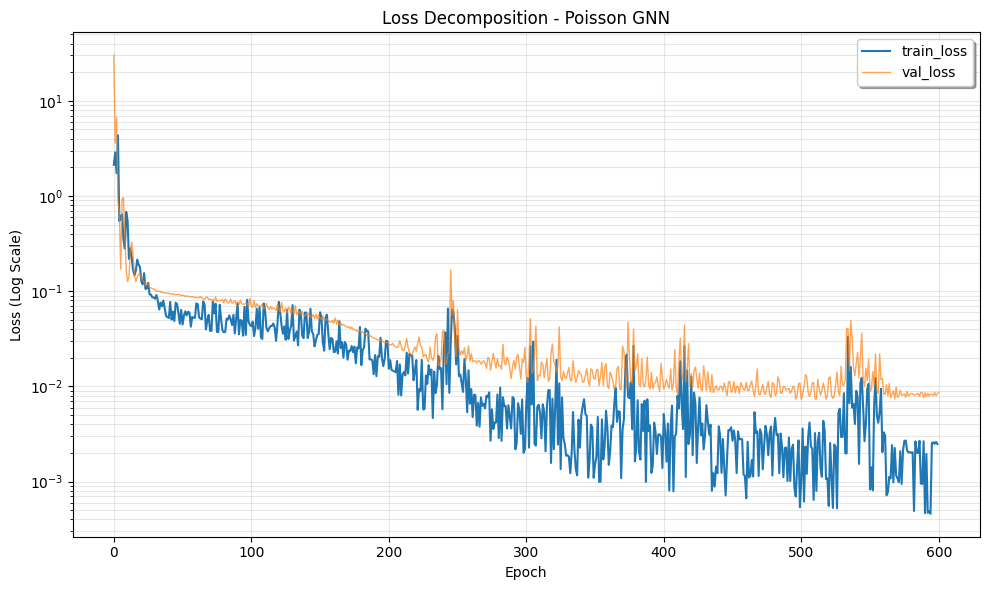

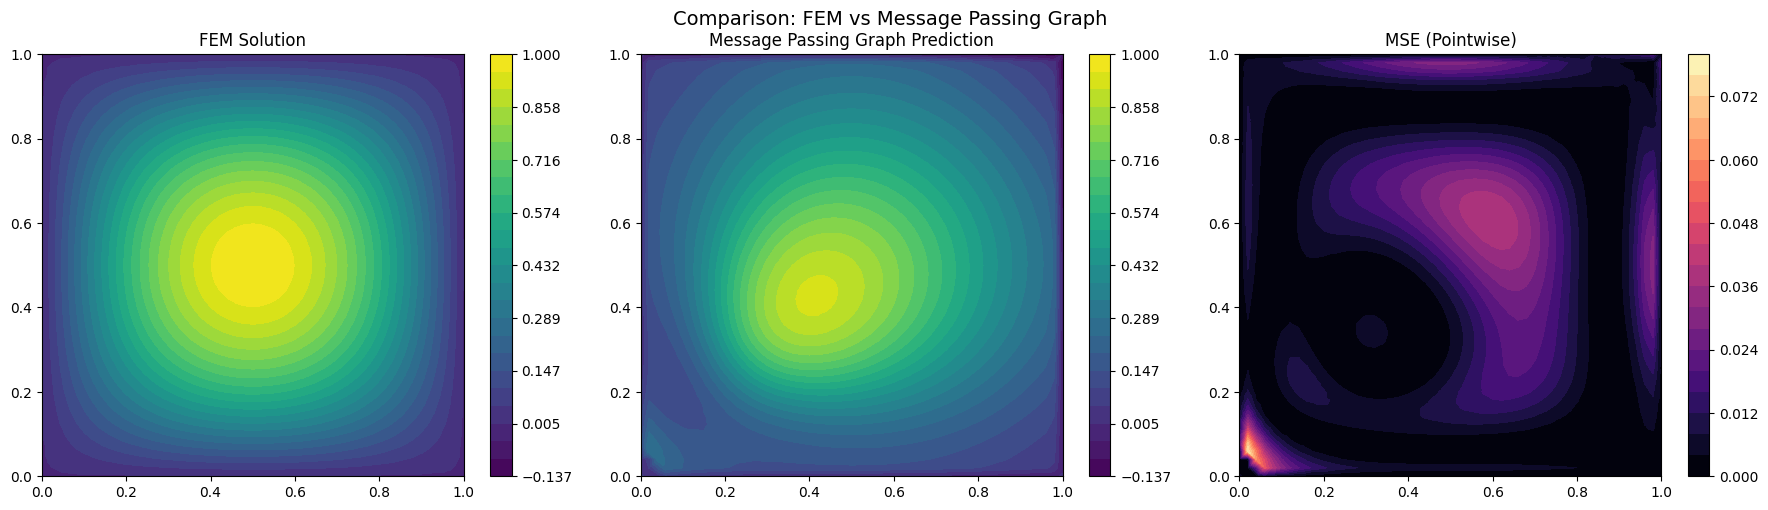

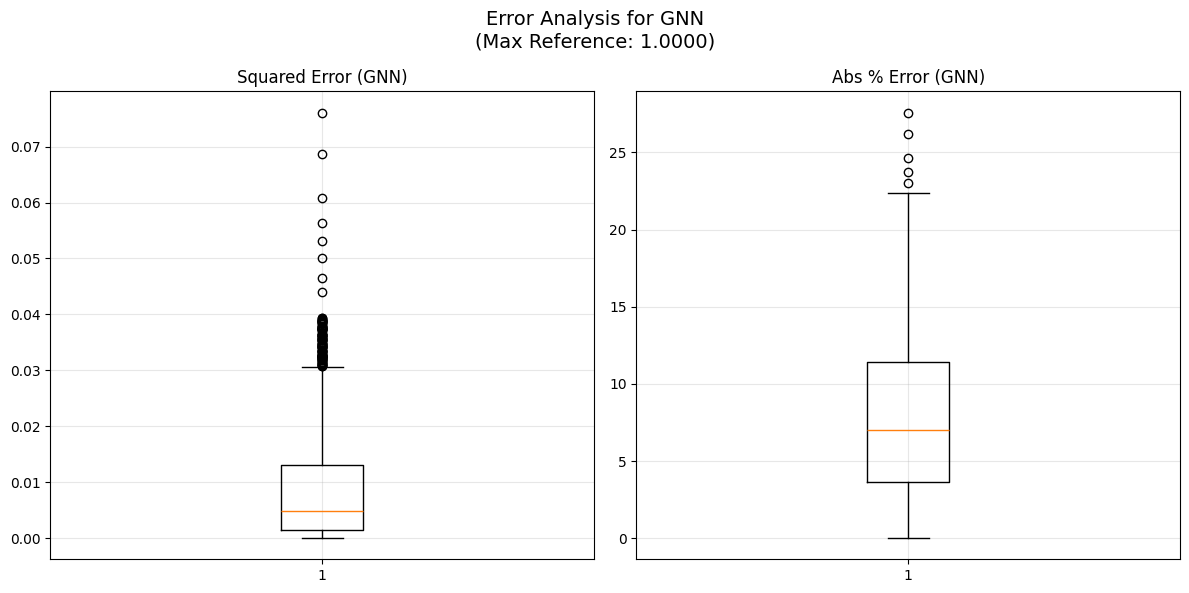

In [17]:
# ============================================================
# Step 1: GNN configuration
# ============================================================
import torch
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Local modules
from FEM.fem_solver import get_problem
from GNN.gnn_module import MessagePassing, DirectSystem
from config.gnn_config import GNN_CONFIG
from utils.gnn_utils import FEM_to_GraphData
from utils.train_utils import GradientMonitor, LossPlotterCallback
from utils.geometry import *

# 0. Configuración de parámetros
GNN_CONFIG.update({
    'geometry_type': 'square',      # domain
    'nx': 10,                       # Mesh resolution 
    'ny': 10,
    'porder': 1,                    # base functions
    'source_type': 'sine',          # source type
    'source_value': 1.0,
    'hidden': 40,
    'num_layers': 2,
    'lr': 1e-3,
    'epochs': 600,
    'batch': 1,
    'layer_norm': True,
    'msg_passes': 6,
    'node_in': 4,           # [x, y, is_boundary, u_out] <-- Gestión de BCs
    'edge_in': 3,           # [dx, dy, dist]
})

geom = geometry_factory(GNN_CONFIG['geometry_type'], x_range=[0, 1], y_range=[0, 1])
train_resolutions = [(2, 2), (5, 5), (8, 8), (10, 10)]  # diferentes mallas para entrenar
val_resolution = (50, 50)                               # Una malla fina para validar

# 1. Generar mallas de ENTRENAMIENTO
train_graphs = []
for nx, ny in train_resolutions:
    print(f"Generando malla de entrenamiento: {nx}x{ny}...")
    prob = get_problem(
        geometry=geom, nx=nx, ny=ny, 
        porder=GNN_CONFIG['porder'], 
        source_type=GNN_CONFIG['source_type']
    )
    train_graphs.append(FEM_to_GraphData(prob))

# 2. Generar malla de VALIDACIÓN
print(f"Generando malla de validación (fina): {val_resolution[0]}x{val_resolution[1]}...")
prob_val = get_problem(
    geometry=geom, nx=val_resolution[0], ny=val_resolution[1], 
    porder=GNN_CONFIG['porder'], 
    source_type=GNN_CONFIG['source_type']
)
val_graph = FEM_to_GraphData(prob_val)

# 3. DataLoaders
# Batch_size=1 es lo ideal aquí porque cada malla tiene un número de nodos distinto
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=1)

# 4. Inicializar Arquitectura y Sistema
# MeshGraphNet: Encoder -> Processor -> Decoder
sample_graph = train_graphs[0]
GNN_CONFIG['node_in'] = sample_graph.x.shape[1]         # p.ej. 4 ([x, y, is_bc, u_ref])
GNN_CONFIG['edge_in'] = sample_graph.edge_attr.shape[1] # p.ej. 3 ([dx, dy, dist])

# Model
mp_layer = MessagePassing(
    node_dim=GNN_CONFIG['node_in'], 
    edge_dim=GNN_CONFIG['edge_in'], 
    **GNN_CONFIG # Aquí cogerá hidden, num_layers, etc.
)
# system_direct: Maneja el bucle de entrenamiento, optimización y métricas
system_direct = DirectSystem(
    mp_layer=mp_layer, 
    msg_passes=GNN_CONFIG['msg_passes'], 
    lr=GNN_CONFIG['lr']
)

# 4. Configurar Callbacks (Igual que en PINN)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=100, mode='min', verbose=True),
    ModelCheckpoint(monitor='val_loss', filename='best_gnn_model'),
    GradientMonitor(verbose=False),
    LossPlotterCallback(model_name="Poisson GNN")
]

# 5. Lanzar Entrenamiento
trainer_gnn = pl.Trainer(
    max_epochs=GNN_CONFIG['epochs'],
    accelerator="auto",
    devices=1,
    callbacks=callbacks,
    log_every_n_steps=1
)

trainer_gnn.fit(system_direct, train_loader, val_loader)

# 6. Evaluación y Plot Comparativo
system_direct.eval()
with torch.no_grad():
    u_gnn_pred = system_direct(val_graph.to(system_direct.device)).cpu().numpy().flatten()

# Rescatamos u_exact y doflocs del objeto prob guardado en graph_data
u_fem = prob_val['u_exact']
coords = prob_val['doflocs']

plot_comparison_with_fem(u_fem, u_gnn_pred, coords, model_name="Message Passing Graph")
plt.show()

plot_error_analysis(u_fem, u_gnn_pred, model_name="GNN")
plt.show()


## 5. PINN vs GNN: Comparative Analysis

Aplicación al Problema de PoissonEn este contexto, la GNN aprende que la variable $u$ en un punto debe satisfacer la relación de vecindad impuesta por el operador Laplaciano $\nabla^2 u = f$. El EdgeProcessor aprende de forma implícita las derivadas espaciales, mientras que el NodeProcessor ajusta el valor de $u$ para minimizar el residuo de la ecuación en toda la malla.


### Recap
- **PINN** learned the physics by looking at the interior PDE residuals. It is mesh-free but requires careful sampling.
- **GNN** learned the behavior of the solution by observing the FEM ground truth. It is extremely fast at inference and understands the domain topology.

| Feature | PINN | GNN (Supervised) |
| :--- | :--- | :--- |
| Need for Mesh | No | Yes |
| Learning Target | PDE Residual | FEM Data |
| Flexibility | High (any geometry) | Medium (restricted to graph) |
| Accuracy | Smooth/Global | Local/Topology-aware |

**Conclusion**: This tutorial demonstrates that both physics-informed and data-driven neural networks can approximate PDE solutions. In advanced cases, we combine these (PiGNN) to use the graph structure while enforcing physics residuals directly on the mesh nodes.